November 25, 2025

##### Changes:

- use of "smart" dataset (only slices that have tumors)
- use of Dice Loss instead of BCE

# The Data Pipeline: 3D .nii file -> 2d image -> torch tensors

In [2]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from brats_utils import BraTSSmartDataset

DATA_ROOT = Path("/Users/michaelbanks/Desktop/AI TXG/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

dataset = BraTSSmartDataset(DATA_ROOT, limit_patients=50)

Preprocessing: Scanning for slices with tumors...
Success! Found 3147 valid slices containing tumors.


##### Quick Data Visualization

Image Shape: torch.Size([1, 240, 240])
Mask Shape: torch.Size([1, 240, 240])


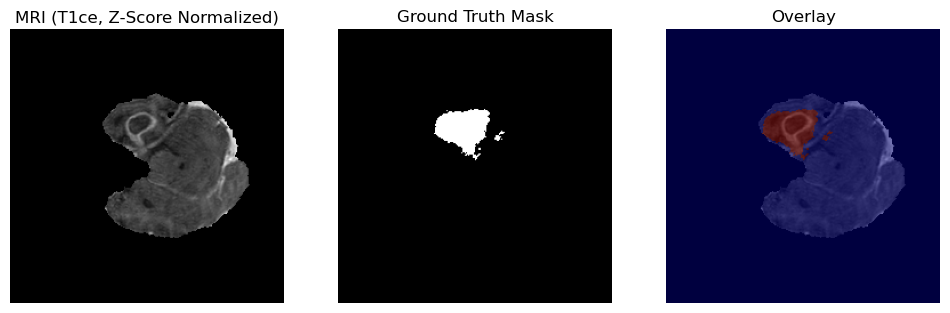

In [3]:
if len(dataset) > 0:
    sample_img, sample_mask = dataset[16] 

    print(f"Image Shape: {sample_img.shape}") 
    print(f"Mask Shape: {sample_mask.shape}")

    def visualize_overlay(img_tensor, mask_tensor):
        img = img_tensor.squeeze().numpy()
        mask = mask_tensor.squeeze().numpy()
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title("MRI (T1ce, Z-Score Normalized)")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='jet', alpha=0.5) 
        plt.title("Overlay")
        plt.axis('off')
        
        plt.show()

    visualize_overlay(sample_img, sample_mask)
else:
    print("ERROR: Dataset is empty. Please check the data path.")

##### The DataLoader

In [22]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

batch_imgs, batch_masks = next(iter(dataloader))

print(f"Batch of Images Shape: {batch_imgs.shape}") 
print(f"Batch of Masks Shape:  {batch_masks.shape}")
# Expected: (16, 1, 240, 240) -> (Batch, Channel, Height, Width)

Batch of Images Shape: torch.Size([16, 1, 240, 240])
Batch of Masks Shape:  torch.Size([16, 1, 240, 240])


# The Model: U-NET

In [23]:
import torch.nn as nn

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2) # 240 -> 120
        
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2) # 120 -> 60
        
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool3 = nn.MaxPool2d(2, 2) # 60 -> 30

        self.bottleneck = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) 
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU()) 

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) 
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU()) 

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) 
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU()) 

        self.final = nn.Conv2d(16, 1, kernel_size=1) 
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        b = self.bottleneck(self.pool3(e3))
        
        d3 = self.up3(b)
        d3 = torch.cat((e3, d3), dim=1) 
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1) 
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1) 
        d1 = self.dec1(d1)
        
        return self.sigmoid(self.final(d1))

##### Quick Shape Check

In [24]:
model = SimpleUNet()

predictions = model(batch_imgs).detach()

print(f"Input Shape:      {batch_imgs.shape}")
print(f"Prediction Shape: {predictions.shape}")

assert predictions.shape == batch_masks.shape
print("SUCCESS: The model output matches the mask shape. Ready to train!")

Input Shape:      torch.Size([16, 1, 240, 240])
Prediction Shape: torch.Size([16, 1, 240, 240])
SUCCESS: The model output matches the mask shape. Ready to train!


##### Set up Device, Loss, and Optimizer

In [25]:
import torch.optim as optim

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success: Using Apple Metal (MPS) Acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Success: Using NVIDIA (CUDA) Acceleration!")
else:
    device = torch.device("cpu")
    print("Using CPU (Slower, but works)")

model = model.to(device)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        intersection = torch.sum(predictions * targets)
        union = torch.sum(predictions) + torch.sum(targets)
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice

criterion = DiceLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

Success: Using Apple Metal (MPS) Acceleration!


# The Training Loop

In [ ]:
num_epochs = 10
history = [] 

print("Starting Training...")

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    for i, (images, masks) in enumerate(dataloader):
        
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()             
        
        outputs = model(images)           
        loss = criterion(outputs, masks)  
        
        loss.backward()                   
        optimizer.step()                  
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    history.append(epoch_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training Finished!")

Starting Training...
Epoch [1/10], Loss: 0.7879
Epoch [1/10], Loss: 0.7879
Epoch [2/10], Loss: 0.7290
Epoch [2/10], Loss: 0.7290
Epoch [3/10], Loss: 0.7156
Epoch [3/10], Loss: 0.7156
Epoch [4/10], Loss: 0.6985
Epoch [4/10], Loss: 0.6985
Epoch [5/10], Loss: 0.5243
Epoch [5/10], Loss: 0.5243
Epoch [6/10], Loss: 0.4373
Epoch [6/10], Loss: 0.4373
Epoch [7/10], Loss: 0.3910
Epoch [7/10], Loss: 0.3910
Epoch [8/10], Loss: 0.3417
Epoch [8/10], Loss: 0.3417
Epoch [9/10], Loss: 0.3050
Epoch [9/10], Loss: 0.3050
Epoch [10/10], Loss: 0.2784
Training Finished!
Epoch [10/10], Loss: 0.2784
Training Finished!


# Validation & Visualization

In [ ]:
model.eval()

test_img, test_mask = dataset[284] 

input_tensor = test_img.unsqueeze(0).to(device)

with torch.no_grad(): 
    prediction = model(input_tensor)

pred_cpu = prediction.squeeze().cpu().numpy()
pred_thresholded = (pred_cpu > 0.5).astype(float)
img_cpu = test_img.squeeze().numpy()
mask_cpu = test_mask.squeeze().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_cpu, cmap='gray')
plt.title("Original MRI")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask_cpu, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(pred_cpu, cmap='gray')
plt.title("Model Prediction (Soft)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(pred_thresholded, cmap='gray')
plt.title("Model Prediction (Threshold > 0.5)")
plt.axis('off')

plt.show()

NameError: name 'model' is not defined

# Next Steps: 

##### Now

- Create test/validation sets out of smart dataset, calculate validation loss each epoch

- Save a checkpoint of the model so you don't have to rerun it

- Keep track of training time

- mess with numworkers

- change epochs to a value when it stops learning

- Moar data (rest of set and augment)

##### A bit later

- Consider segmenting edema instead of whole tumor 

##### Down the road

- Have some images in the test set that don't have a tumor

- Consider penalizing the model for guessing wrong/random dots in the brain

- Test on SAM?